 	Macrophage/ monocyte lineage cells isolated from E14.5 whole body were subjected to the sc RNA-seq. All samples included tdTomato expressing cells derived from E8.5 or E9.5 erythromyeloid progenitors in the yolk-sac.

In [1]:
import pandas as pd
import gzip
import scipy
import anndata as ad
import scanpy as sc
import decoupler as dc
import numpy as np
import os
import pandas as pd

In [2]:
wkdir = '/home/jing/Downloads/lypi_DATA/GSE125088/'

In [3]:
barcodes = pd.read_csv(os.path.join(wkdir,'GSE125088_Cx3cr1_Csf1r_new.barcodes.tsv.gz'), sep="\t", compression="gzip", header=None)
features = pd.read_csv(os.path.join(wkdir,'GSE125088_Cx3cr1_Csf1r_new.features.tsv.gz'), sep="\t", compression="gzip", header=None)
with gzip.open(os.path.join(wkdir,'GSE125088_Cx3cr1_Csf1r_new.matrix.mtx.gz'), "rt") as f:
    sparse_matrix = scipy.io.mmread(f)
matrix = sparse_matrix.todense()

In [4]:
adata = ad.AnnData(X=matrix.T)
adata.obs_names = barcodes.iloc[:, 0].values
adata.var_names = features.iloc[:, 1].values
adata.var_names_make_unique()
if isinstance(adata.X, np.matrix):
    adata.X = np.array(adata.X)

In [5]:
experiment_labels = adata.obs_names.str.split("-").str[-1]

# Get unique experiment identifiers
unique_experiments = experiment_labels.unique()
print(unique_experiments)
experiment_labels.value_counts()

Index(['1', '2', '3', '4'], dtype='object')


4    13389
1     9851
3     8058
2     7750
Name: count, dtype: int64

In [6]:
adata.obs['experiment'] = experiment_labels

In [7]:
#Proceed with combinations of 1,3 and 2, 4(gender-specific DE) corresponding to figure 4a and h 
#19,598 4a   batch 2+4
#16,169 4h   batch 1+3

In [58]:
csf1r_adata = adata[(adata.obs['experiment'] == '2')|(adata.obs['experiment'] == '4')]
display(csf1r_adata)

View of AnnData object with n_obs × n_vars = 21139 × 31054
    obs: 'experiment'

In [50]:
cs3rf_adata = adata[(adata.obs['experiment'] == '1')|(adata.obs['experiment'] == '3')]
display(cs3rf_adata)

View of AnnData object with n_obs × n_vars = 17909 × 31054
    obs: 'experiment'

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


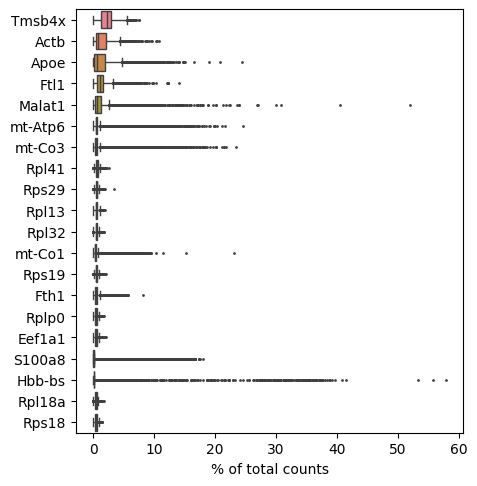

In [32]:
sc.pl.highest_expr_genes(csf1r_adata, n_top=20)

In [33]:
sc.pp.filter_cells(csf1r_adata, min_genes=200)
sc.pp.filter_genes(csf1r_adata, min_cells=3)

In [34]:
# annotate the group of mitochondrial genes as "mt"
csf1r_adata.var["mt"] = csf1r_adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    csf1r_adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

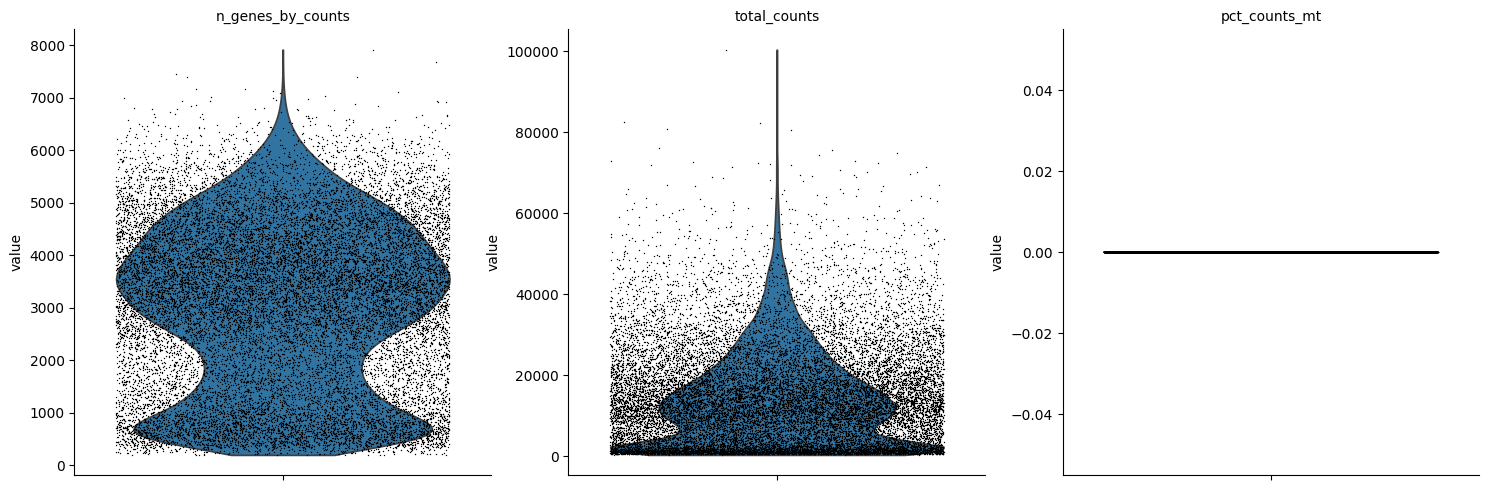

In [35]:
sc.pl.violin(
    csf1r_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

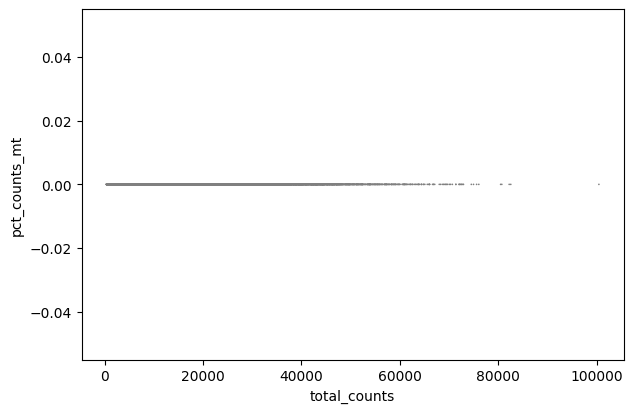

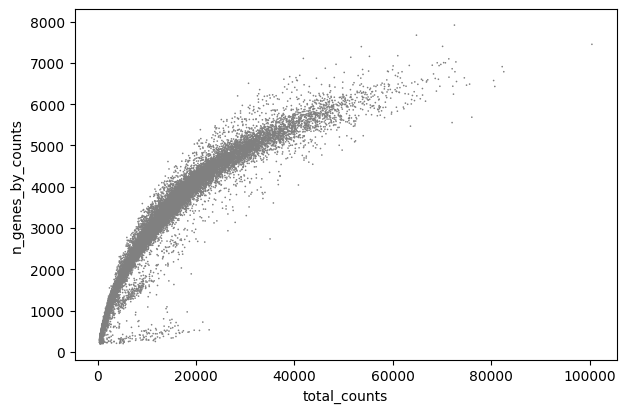

In [36]:
sc.pl.scatter(csf1r_adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(csf1r_adata, x="total_counts", y="n_genes_by_counts")

In [40]:
csf1r_adata = csf1r_adata[csf1r_adata.obs.n_genes_by_counts < 6001, :]
csf1r_adata = csf1r_adata[csf1r_adata.obs.pct_counts_mt < 5, :].copy()

In [63]:
csf1r_adata

AnnData object with n_obs × n_vars = 21139 × 31054
    obs: 'experiment', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [59]:
# Basic pre-processing steps   
csf1r_adata.layers["counts"] = csf1r_adata.X.copy()
sc.pp.normalize_total(csf1r_adata)
sc.pp.log1p(csf1r_adata)
sc.pp.highly_variable_genes(csf1r_adata, n_top_genes=2000)
sc.tl.pca(csf1r_adata)
sc.pp.neighbors(csf1r_adata)
sc.tl.umap(csf1r_adata)

/tmp/ipykernel_763768/3448366287.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  csf1r_adata.layers["counts"] = csf1r_adata.X.copy()


In [61]:
sc.tl.leiden(csf1r_adata, resolution=0.5,random_state=0)

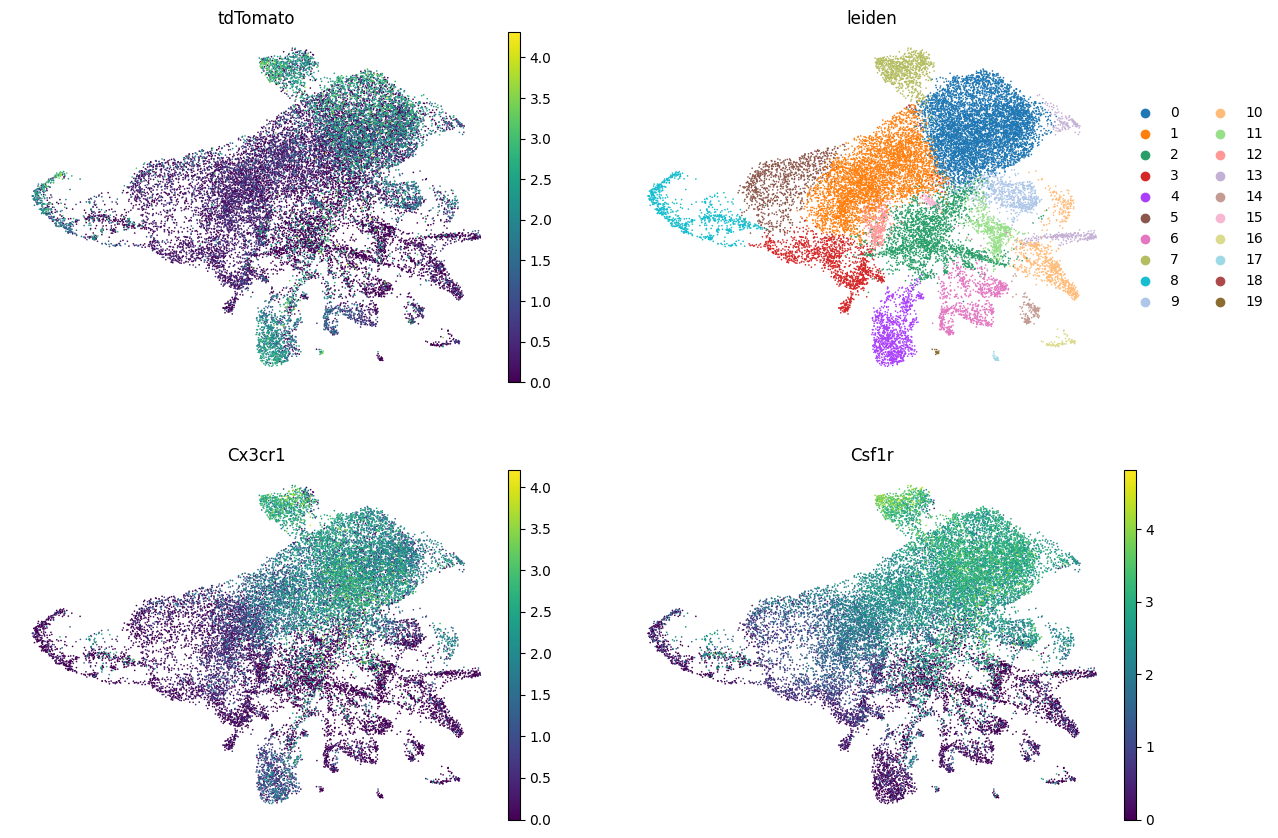

In [62]:
sc.pl.umap(csf1r_adata,color=['tdTomato','leiden','Cx3cr1','Csf1r'],ncols=2,frameon=False)

### fig 4h cs3rf_adata

In [51]:
# Basic pre-processing steps   
cs3rf_adata.layers["counts"] = cs3rf_adata.X.copy()
sc.pp.normalize_total(cs3rf_adata)
sc.pp.log1p(cs3rf_adata)
sc.pp.highly_variable_genes(cs3rf_adata, n_top_genes=2000)
sc.tl.pca(cs3rf_adata)
sc.pp.neighbors(cs3rf_adata)
sc.tl.umap(cs3rf_adata)

/tmp/ipykernel_763768/1352000246.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  cs3rf_adata.layers["counts"] = cs3rf_adata.X.copy()


In [55]:
sc.tl.leiden(cs3rf_adata, resolution=1,random_state=0)

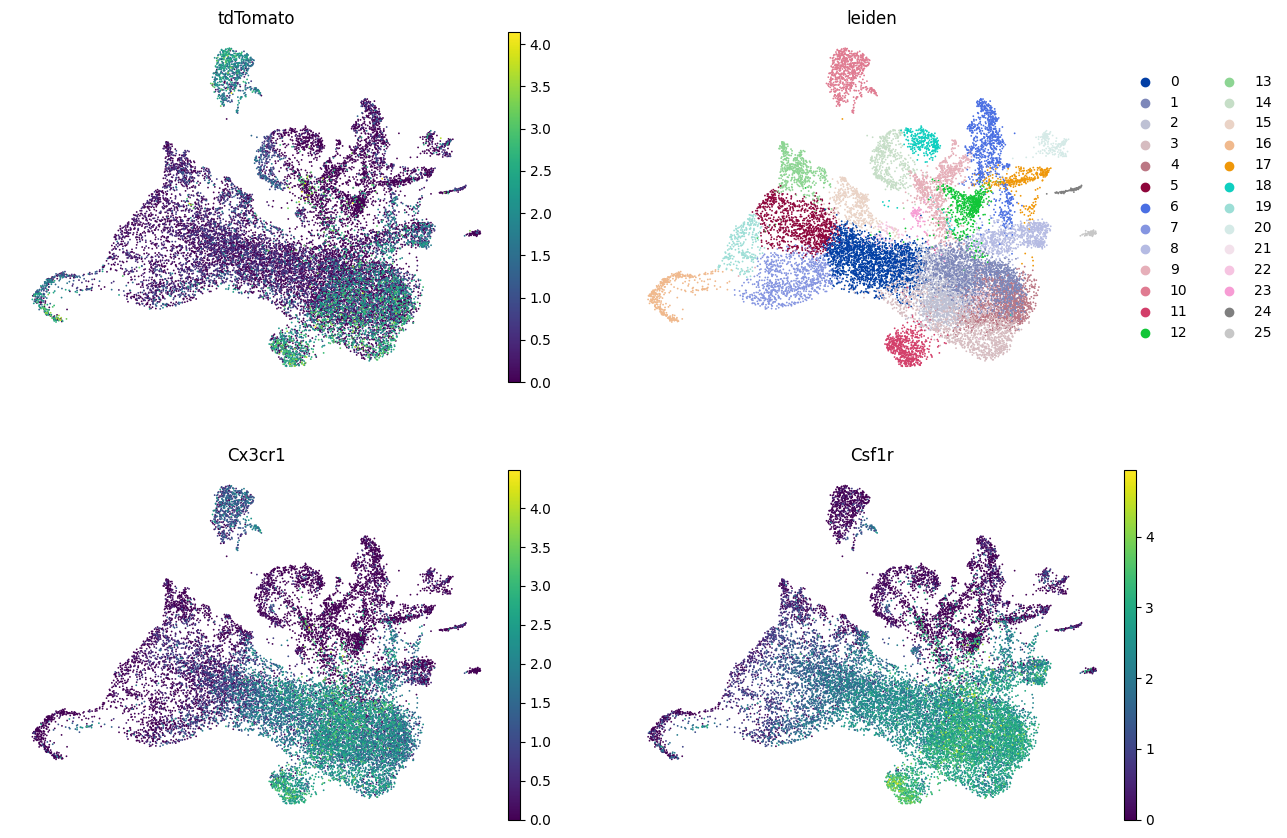

In [56]:
sc.pl.umap(cs3rf_adata,color=['tdTomato','leiden','Cx3cr1','Csf1r'],ncols=2,frameon=False)

In [17]:
adata

AnnData object with n_obs × n_vars = 39048 × 31054
    obs: 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

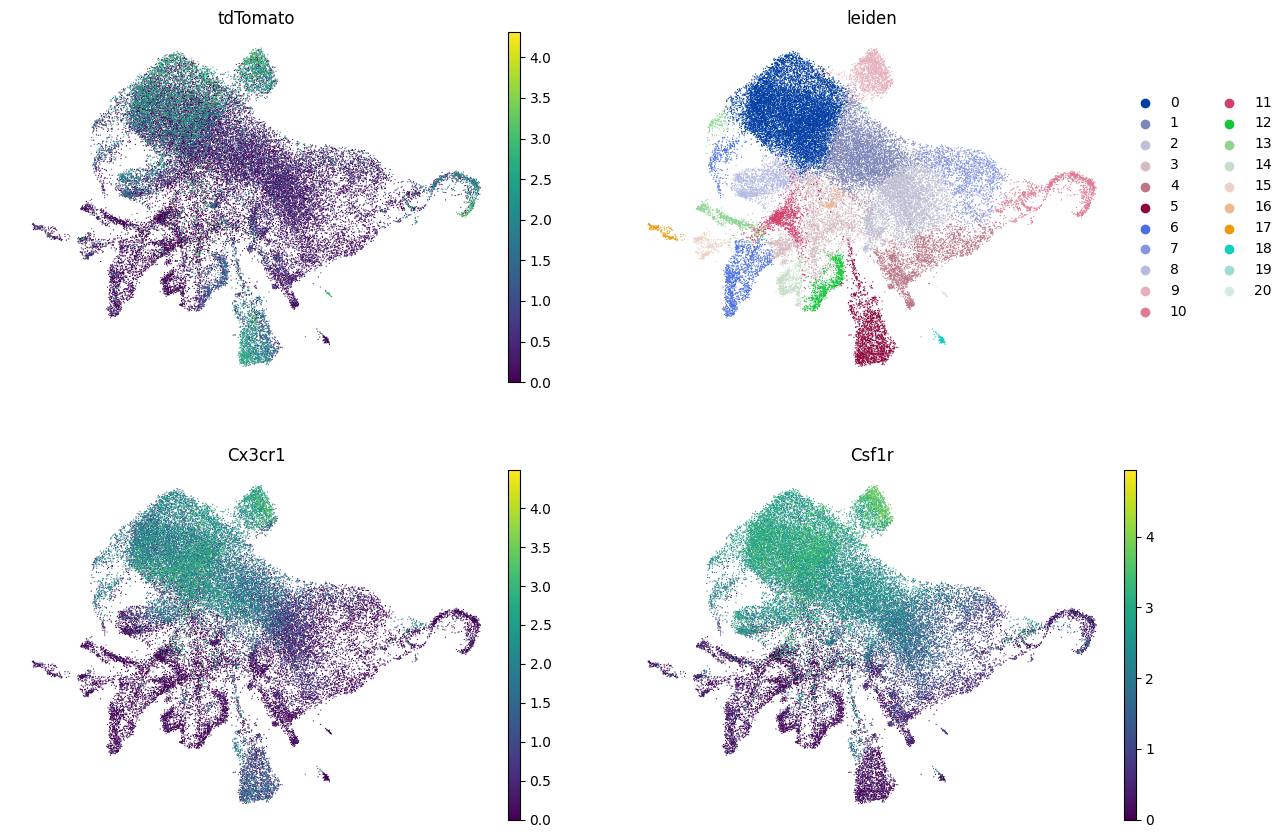

In [95]:
sc.pl.umap(adata,color=['tdTomato','leiden','Cx3cr1','Csf1r'],ncols=2,frameon=False)

In [87]:
adata.obs['cell_type'] = 't'

In [88]:
adata.obs.loc[adata.obs['leiden'] == '10', 'cell_type'] = 'Neutrophils'
adata.obs.loc[adata.obs['leiden'] == '14', 'cell_type']  ='Erythrocytes'

In [63]:
#0,5,8,1
adata.obs.loc[adata.obs['leiden'] == '1', 'cell_type']  ='Macrophages'

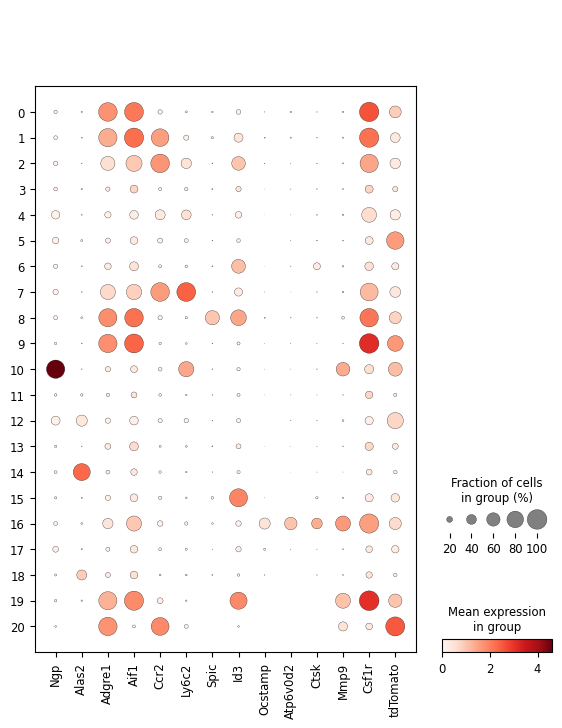

In [86]:
sc.pl.dotplot(adata, var_names=["Ngp","Alas2", "Adgre1", "Aif1", "Ccr2", "Ly6c2", "Spic","Id3" ,'Ocstamp','Atp6v0d2','Ctsk',
                                'Mmp9','Csf1r','tdTomato'], groupby='leiden' )

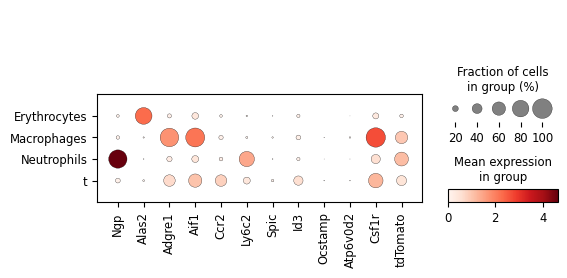

In [75]:
sc.pl.dotplot(adata, var_names=["Ngp","Alas2", "Adgre1", "Aif1", "Ccr2", "Ly6c2", "Spic","Id3" ,'Ocstamp','Atp6v0d2','Csf1r','tdTomato'], groupby='cell_type' )

In [ ]:
#cluster 12 Neutrophils
#cluster 18 Erythrocytes
#

# NGP neutrophiles
# Alas 2 erythorsites
# Cluster 22 osteoblasts
# adgre1, aif1 machrophages
# ccr2 ly6c2 monocytes
# spic id3, kuppfer cells and splenic red pulp
# Erythroid precursor cells

In [ ]:
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

In [ ]:


"MRC1", "LYVE1", "TREM2", "HEXB", "CCR2", "IFITM3", "TDTOMATO", 
,"LY6G", "CX3CR1",  "PECAM1", "CDH5", 
                               "CTSK", "MMP9", "OCSTAMP", "NFATC1", "CSF1R", "TDTOMATO", "GATA2", "HES1",
                        "MRC1", "GAS6", "CXCL2", "RPGRIP1", "MPO", "FLT3",  "TUBB3", "COL1A1",
# NGP neutrophiles
# Alas 2 erythorsites
# Cluster 22 osteoblasts
# adgre1, aif1 machrophages
# ccr2 ly6c2 monocytes
# spic id3, kuppfer cells and splenic red pulp
# Erythroid precursor cells